In [1]:
%matplotlib inline

This will make all the `matplotlib` images appear in the notebook.

In [7]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import sqlite3

from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

Let's connect to our data warehouse and read the information into Panda series.

In [5]:
conn = sqlite3.connect('../2 - get/meetup.db')
cursor = conn.cursor()

In [8]:
events = pd.read_sql('SELECT * FROM event', conn)
events['event_id'] = events['event_id'].astype('str')
events['venue_city'] = events['venue_city'].astype('category')
events['event_time'] = events['event_time'].astype('category')
events = events.drop('status', 1)
events = events.drop('link', 1)
events['duration'] = events['duration'] / 3600000
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   event_id        814 non-null    object  
 1   event_date      814 non-null    object  
 2   event_time      814 non-null    category
 3   rsvp_count      814 non-null    int64   
 4   waitlist_count  814 non-null    int64   
 5   duration        814 non-null    float64 
 6   venue_lat       762 non-null    float64 
 7   venue_lon       762 non-null    float64 
 8   venue_city      762 non-null    category
dtypes: category(2), float64(3), int64(2), object(2)
memory usage: 50.3+ KB


Instruction says to not use linear regression and Naive Bayes and stick to the source materials from Lab 6. The following work is based from Lab 6 solution provided in the class.

RSVP is an abbreviation of the French phrase 'Repondez, s'il vous plaît'. It translates to 'Respond, if you please' or, better still, 'Respond please. I want to predict the next event RSVP with penalty for errors. Let's use the Mean Squared Error as our loss function and the mean as our prediction.

In [9]:
rsvp_predict = events["rsvp_count"].mean()
rsvp_predict

10.968058968058967

 I am going to assume the usual 95% error bounds. At the lower end, we have:

In [10]:
rsvp_std = events["rsvp_count"].std()
rsvp_error = rsvp_std * 1.96
print(rsvp_error)

20.18167931988092


In [11]:
rsvp_predict, rsvp_predict - rsvp_error, rsvp_predict + rsvp_error

(10.968058968058967, -9.213620351821953, 31.14973828793989)

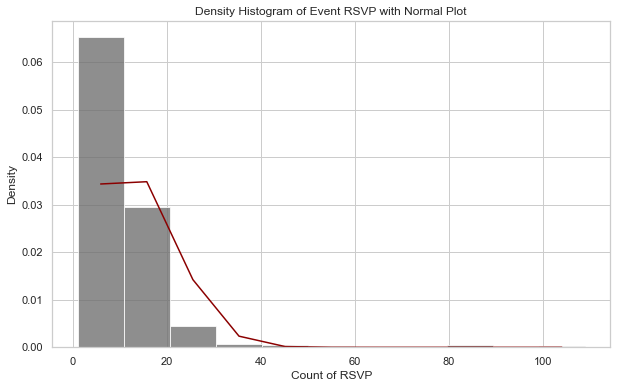

In [16]:
from scipy.stats import norm

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(events['rsvp_count'], color="DimGray", density=True, bins=11, alpha=0.75)
axes.set_xlabel("Count of RSVP")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of Event RSVP with Normal Plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

rings_mean = events["rsvp_count"].mean()
rings_std  = events["rsvp_count"].std()
ys = [norm.pdf( k, loc=rings_mean, scale=rings_std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

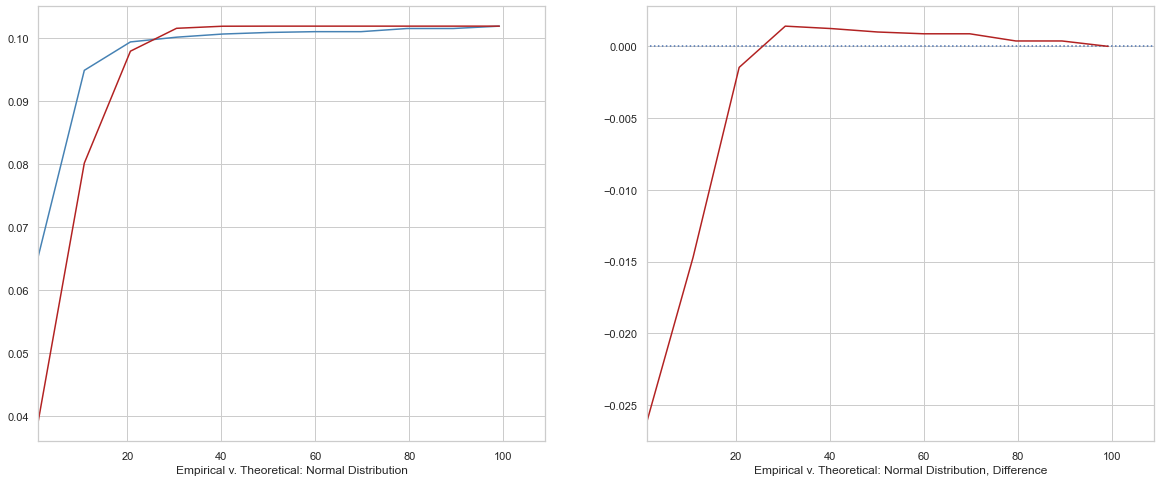

In [15]:
figure = plt.figure(figsize=(20, 8))

abalone_rings_mn = events['rsvp_count'].min()
abalone_rings_mx = events['rsvp_count'].max()

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(events['rsvp_count'], bins=11, density=True)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="steelblue")
axes.set_xlim((abalone_rings_mn, abalone_rings_mx))

sampled_data = [rings_mean + r * rings_std for r in np.random.standard_normal(10000)]
values2, base = np.histogram(sampled_data, bins=base, density=True)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
axes.set_xlim((abalone_rings_mn, abalone_rings_mx))
axes.set_xlabel("Empirical v. Theoretical: Normal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((abalone_rings_mn, abalone_rings_mx))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel("Empirical v. Theoretical: Normal Distribution, Difference")

plt.show()
plt.close()

Note that the empirical and theoretical plots for normal distribution are very close. The difference chart on the right gives us an estimation and approximation of how close the number of reservation is. Ideally, it'll be nice to have a flat horizontal line about y=0, but here we can see our model is pretty good except around the mean (about 20 RSVPs).

In [17]:
events.rsvp_count.describe()

count    814.000000
mean      10.968059
std       10.296775
min        1.000000
25%        6.000000
50%        9.000000
75%       12.000000
max      109.000000
Name: rsvp_count, dtype: float64

This is a very large range going from one attendee to 109.

In [18]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  1


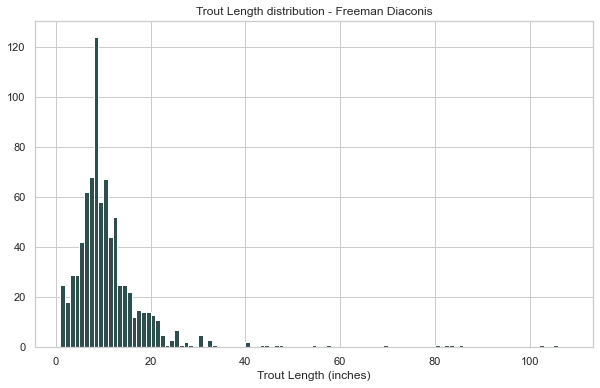

In [19]:
h = freeman_diaconis(events.rsvp_count)
print("Freeman Diaconis: ", h)
mn = int(events.rsvp_count.min())
mx = int(events.rsvp_count.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(events.rsvp_count,bins=bins, color="darkslategray")
axes.set_title("Event RSVP distribution - Freeman Diaconis")
axes.set_xlabel("RSVP")

plt.show()
plt.close()